# Practica 1: Sensado y Análisis de Audio

Ciencia de Datos para Sensores Inteligentes/Tópicos Selectos en Sistemas Interactivos

Alumno: Mario Alberto Lizarraga Reyes

# Para quien califique:

Para este notebook intenté una dinámica distinta, en teoría los modelos ya están procesados y solo se tiene que ejecutar el ultimo bloque siempre y cuando se descargue la carpeta completa (Modifiqué la estructura de los audios), en caso de que sea necesario correr todo el código, como aviso el primer bloque toma aproximadamente dos minutos en correr en mi sistema.


In [14]:

import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Path de los audios (La carpeta está en el git como WAV-set)
directory = r'C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\Scripts\Escuela\CDSI\WAV-set'

# Se remueven modelos entrenados previamente para poder hacer cambios sin tener que estar borrando a mano
for method in [1, 2, 3]:
    if os.path.exists(f'model_method_{method}.pkl'):
        os.remove(f'model_method_{method}.pkl')
    if os.path.exists(f'scaler_method_{method}.pkl'):
        os.remove(f'scaler_method_{method}.pkl')
    if os.path.exists(f'features_method_{method}.csv'):
        os.remove(f'features_method_{method}.csv')
if os.path.exists('label_encoder.pkl'):
    os.remove('label_encoder.pkl')

# Constantes
SAMPLE_RATE = 22050
DURATION = 3  # Segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Ruidoooo
def load_noise_files(noise_dir):
    noise_files = []
    for file in os.listdir(noise_dir):
        if file.endswith('.wav') or file.endswith('.mp3'):
            audio, _ = librosa.load(os.path.join(noise_dir, file), sr=SAMPLE_RATE, duration=DURATION)
            if len(audio) < SAMPLES_PER_TRACK:
                padding = SAMPLES_PER_TRACK - len(audio)
                audio = np.pad(audio, (0, padding), mode='constant')
            noise_files.append(audio)
    return noise_files

# Definición de funciones para pre procesamiento
def load_audio_file(file_path, duration=DURATION, sample_rate=SAMPLE_RATE):
    audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    if len(audio) < SAMPLES_PER_TRACK:
        padding = SAMPLES_PER_TRACK - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        audio = audio[:SAMPLES_PER_TRACK]
    return audio

def reduce_noise(audio, sr=SAMPLE_RATE):
    return librosa.effects.preemphasis(audio)

def augment_audio(audio, noise_files):
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise

    audio_with_real_noise = []
    for noise_sample in noise_files:
        if len(noise_sample) == len(audio):
            mixed_audio = audio + 0.02 * noise_sample
            audio_with_real_noise.append(mixed_audio)

    audio_pitch_shift = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=4)
    audio_stretch = librosa.effects.time_stretch(audio, rate=0.8)

    return [audio_noise, audio_pitch_shift, audio_stretch] + audio_with_real_noise

# Función para extracción de features usada para el data set y también en la captura en tiempo real
def extract_features(audio, sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    rmse = librosa.feature.rms(y=audio)
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(spectral_contrast, axis=1),
        np.mean(zero_crossing_rate),
        np.mean(rmse),
        tempo
    ])

    return features

# Procesado de audios (Llamado a las demás funciones)
def process_audio_files(directory, noise_dir='noise'):
    dataframes = {1: [], 2: [], 3: []}
    labels = {1: [], 2: [], 3: []}
    noise_files = load_noise_files(os.path.join(directory, noise_dir))

    for filename in os.listdir(directory):
        if filename.endswith(".wav") or filename.endswith(".mp3") and not filename.startswith('noise'):
            name, method_audio = filename.rsplit('-', 1)
            method_part, _ = method_audio.split('.')
            method = int(method_part[:2])

            if method not in dataframes:
                continue

            file_path = os.path.join(directory, filename)
            audio = load_audio_file(file_path)
            audio = reduce_noise(audio)
            features = extract_features(audio)

            dataframes[method].append(features)
            labels[method].append(name)

            # Data augmentation
            augmented_audios = augment_audio(audio, noise_files)
            for aug_audio in augmented_audios:
                aug_features = extract_features(aug_audio)
                dataframes[method].append(aug_features)
                labels[method].append(name)

    le = LabelEncoder()

    for method, features in dataframes.items():
        method_labels = labels[method]
        encoded_labels = le.fit_transform(method_labels)

        df = pd.DataFrame(features)
        df['label'] = encoded_labels
        df['person'] = method_labels

        # Vectores en csv para poder revisarlos a mano
        df.to_csv(f'features_method_{method}.csv', index=False)

    joblib.dump(le, 'label_encoder.pkl')

# Llamado a la función para el procesamiento de los audios en base a la carpeta WAV-set 
process_audio_files(directory)


# Entrenamiento del modelo

Para el entrenamiento del modelo intenté distintas alternativas, sin embargo el accuracy era bajo, esta alternativa me da un buen accuracy, sin embargo no logra identificarme, me detecta como Joan o como Francisco, los modelos iniciales me detectaban como mujer.

--- Entrenando modelo para el método 1 ---
Cross-Validation Scores: [0.8956044  0.95879121 0.93406593 0.95879121 0.94230769]
Accuracy: 93.79%
Test Accuracy: 93.96%
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       1.00      0.92      0.96        13
           4       0.93      1.00      0.96        13
           5       1.00      1.00      1.00        13
           6       0.79      0.85      0.81        13
           7       0.93      1.00      0.96        13
           8       0.81      1.00      0.90        13
           9       1.00      0.92      0.96        13
          10       0.92      0.85      0.88        13
          11       1.00      1.00      1.00        13
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00        13

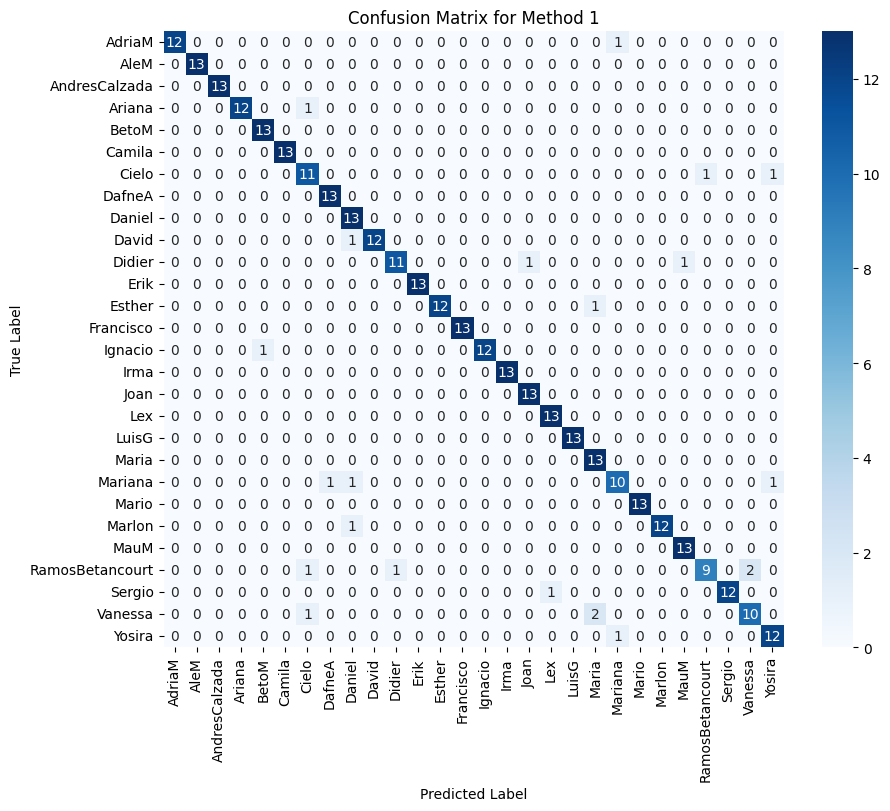

--- Entrenando modelo para el método 2 ---
Cross-Validation Scores: [0.96978022 0.93681319 0.98351648 0.95604396 0.96703297]
Accuracy: 96.26%
Test Accuracy: 97.53%
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        13
           2       1.00      0.92      0.96        13
           3       1.00      1.00      1.00        13
           4       0.93      1.00      0.96        13
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       0.92      0.92      0.92        13
           8       0.93      1.00      0.96        13
           9       1.00      0.92      0.96        13
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        13

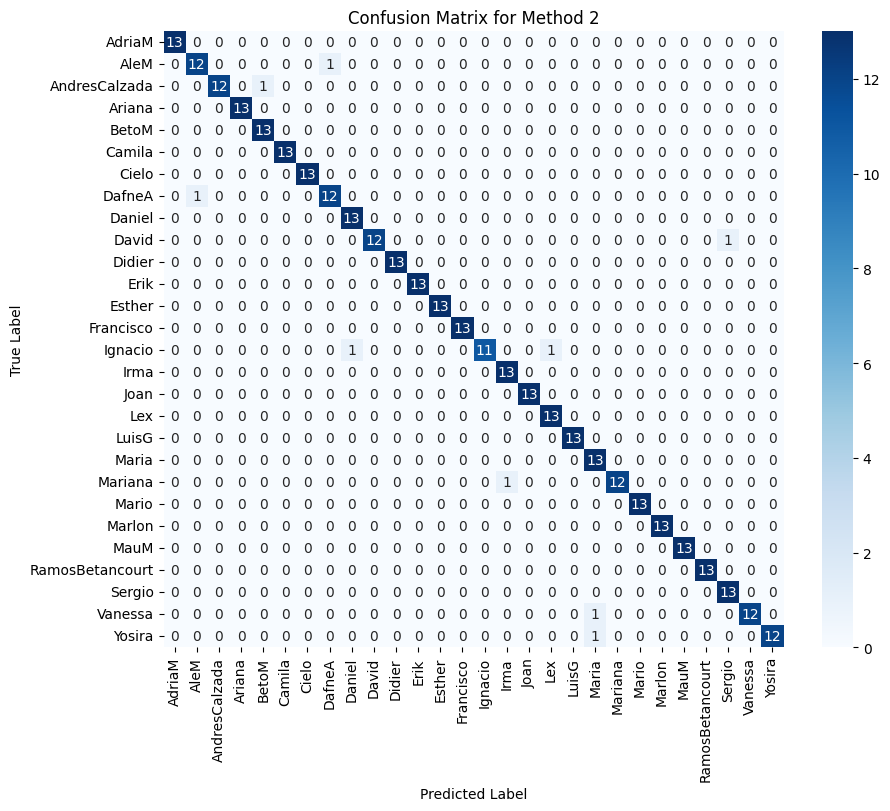

--- Entrenando modelo para el método 3 ---
Cross-Validation Scores: [0.78846154 0.8956044  0.84615385 0.85714286 0.78571429]
Accuracy: 83.46%
Test Accuracy: 86.26%
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.92      0.85      0.88        13
           2       0.93      1.00      0.96        13
           3       0.93      1.00      0.96        13
           4       0.79      0.85      0.81        13
           5       0.87      1.00      0.93        13
           6       0.77      0.77      0.77        13
           7       0.81      1.00      0.90        13
           8       0.87      1.00      0.93        13
           9       0.62      0.62      0.62        13
          10       1.00      1.00      1.00        13
          11       0.91      0.77      0.83        13
          12       0.92      0.85      0.88        13
          13       1.00      1.00      1.00        13

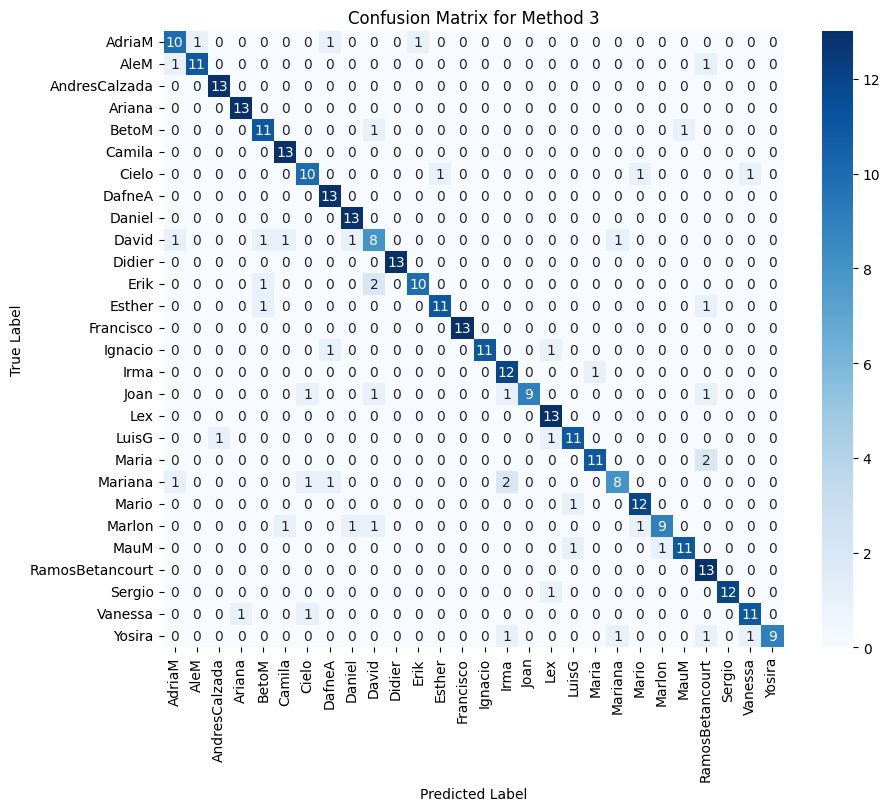

In [16]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamiento de los modelos
for method in [1, 2, 3]:
    print(f"--- Entrenando modelo para el método {method} ---")
    
    df = pd.read_csv(f'features_method_{method}.csv')
    X = df.drop(['label', 'person'], axis=1).values
    y = df['label'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train, y_train)

    # Cross-validation
    cv_scores = cross_val_score(classifier, X, y, cv=5)
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Accuracy: {cv_scores.mean() * 100:.2f}%")

    # Predicciones
    y_pred = classifier.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Reporte
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Plot bonito de matrices
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['person'].unique(), yticklabels=df['person'].unique())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Method {method}')
    plt.show()

    # Guardar modelos
    joblib.dump(classifier, f'model_method_{method}.pkl')
    joblib.dump(scaler, f'scaler_method_{method}.pkl')


# Función para grabado y predicción en tiempo real

A pesar de que se menciona que esta función tenía que quedar como un agente, decidí mantenerlo simple ya que me parecía confuso durante mis pruebas tener que dar un input y que después me grabara, por lo que decidí dejar una ventana corta de grabado en cuanto se hace el print "Grabando..."

In [23]:

import sounddevice as sd
import librosa
import numpy as np
import joblib

# Constantes
SAMPLE_RATE = 22050
DURATION = 3  
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Cargar modelos
models = {method: joblib.load(f'model_method_{method}.pkl') for method in [1, 2, 3]}
scalers = {method: joblib.load(f'scaler_method_{method}.pkl') for method in [1, 2, 3]}
label_encoder = joblib.load('label_encoder.pkl')

# Funciones para grabado y predicción
def record_audio():
    print("Grabando...")
    audio = sd.rec(int(SAMPLES_PER_TRACK), samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    print("Grabado completo.")
    return audio.flatten()

def extract_features(audio, sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    rmse = librosa.feature.rms(y=audio)
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(spectral_contrast, axis=1),
        np.mean(zero_crossing_rate),
        np.mean(rmse),
        tempo
    ])

    return features

def predict(audio):
    features = extract_features(audio).reshape(1, -1)
    predictions = {}

    for method in models:
        scaled_features = scalers[method].transform(features)
        pred = models[method].predict(scaled_features)
        predictions[method] = label_encoder.inverse_transform(pred)[0]

    return predictions

# Llamado a las funciones para grabado y predicción
audio = record_audio()
predictions = predict(audio)
for method, prediction in predictions.items():
    print(f"Prediction for Method {method}: {prediction}")


Grabando...
Grabado completo.
Prediction for Method 1: Yosira
Prediction for Method 2: Joan
Prediction for Method 3: Joan


Como conclusión, a pesar de no tener errores de clasificación en mis audios, noto que me suele clasificar como Joan o Francisco en mi modelo con mejor score, tal vez el problema es mi voz, sin embargo no pude hacerlo funcionar mejor, y no pude ver cual era la predicción con demás personas y no me queda tiempo para hacer más cosas, sin embargo fue una práctica interesante a la que le dediqué mucho tiempo y que me mantuvo entretenido por lo que me quedo con una buena experiencia en general:)